In [1]:
import os
import sys
sys.path.append("..")
import torch
import subprocess
import traceback
import warnings
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

from tqdm import tqdm
# n.pyimport hydra
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from src.metric import LWLRAP
from src.models import get_model
import src.configuration as C
import src.utils as utils
from src.metric import LWLRAP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger

/opt/anaconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
config_str = """
globals:
  seed: 42
  device: cuda
  max_epochs: 30
  output_dir: output
  timestamp: None
  pretrained: False
  pretrained_model_dir: None
  only_pred: False
  folds:
    - 0
    - 1
    - 2
    - 3
    - 4
  debug: False
  kaggle: False

mlflow:
    experiment_name: rainforest
    tags:
      timestamp: None
      model_name: None
      loss_name: None
      hash_value: None
      message: baseline
data:
  root: ./
  use_train_data:
    - tp
    - fp
  train_tp_df_path: input/rfcx-species-audio-detection/train_tp.csv
  train_fp_df_path: input/rfcx-species-audio-detection/train_fp.csv
  train_audio_path: input/rfcx-species-audio-detection/train
  test_audio_path: input/rfcx-species-audio-detection/test
  sub_df_path: input/rfcx-species-audio-detection/sample_submission.csv


dataset:
  name: SpectrogramDataset
  height: 224
  width: 400
  period: 10
  shift_time: 10
  strong_label_prob: 1.0
  params:
    melspec:
      n_fft: 2048
      n_mels: 128
      fmin: 80
      fmax: 15000
      power: 2.0
    pcen:
      gain: 0.98
      bias: 2
      power: 0.5
      time_constant: 0.4
      eps: 0.000001

loss:
  name: LSEPStableLoss  # LSEPStableLoss LSEPLoss BCEWithLogitsLoss FocalLoss
  params:
    output_key: logit

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10

split:
  name: StratifiedKFold  # MultilabelStratifiedKFold  StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

model:
  name: EfficientNetSED
  output_key: logit
  params:
    base_model_name: efficientnet-b2
    pretrained: True
    num_classes: 24

loader:
  train:
    batch_size: 1
    shuffle: True
    num_workers: 10
  valid:
    batch_size: 1
    shuffle: False
    num_workers: 10
  test:
    batch_size: 1
    shuffle: False
    num_workers: 10

transforms:
  train:

  valid:

  test:

mixup:
  flag: False
  alpha: 0.2
  prob: 0.5

"""

In [4]:
import yaml
# config
config = yaml.safe_load(config_str)
device = "cuda"
PSEUDO_THR = 0.5

# data
df, datadir = C.get_metadata(config)
all_recording_ids = df["recording_id"].values

In [6]:

import cv2
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch.utils.data as data
import warnings
from pathlib import Path

PSEUDO_LABEL_VALUE = 1.0
"""
valid/testではtime flagは使わない
60s分にaudioの長さを揃える
10s単位に分割してリスト化してimage変換
"""
class SpectrogramDataset(data.Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 phase: str,
                 datadir: Path,
                 height: int,
                 width: int,
                 period: int,
                 shift_time: int,
                 strong_label_prob: int, 
                 waveform_transforms=None,
                 spectrogram_transforms=None,
                 melspectrogram_parameters={},
                 pcen_parameters = {}):
        self.df = df
        self.phase = phase
        self.datadir = datadir
        self.height = height
        self.width = width
        self.period = period
        self.shift_time = shift_time
        self.strong_label_prob = strong_label_prob
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.pcen_parameters = pcen_parameters
        self.train_pseudo = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        
        # train_pseudo = self.train_pseudo.sample(frac=0.5)  # 毎回50%sampling
        train_pseudo = self.train_pseudo
        
        sample = self.df.loc[idx, :]
        recording_id = sample["recording_id"]
        y, sr = sf.read(self.datadir / f"{recording_id}.flac")  # for default
        effective_length = sr * self.period
        total_time = 60  # 音声を全て60sに揃える
        y = adjust_audio_length(y, sr, total_time)
        if self.waveform_transforms:
            y = self.waveform_transforms(y)

        if self.phase == 'train':
            p = random.random()
            if p < self.strong_label_prob:
                y, labels = strong_clip_audio(self.df, y, sr, idx, effective_length, train_pseudo)
            else:
                y, labels = random_clip_audio(self.df, y, sr, idx, effective_length, train_pseudo)
            image = wave2image_normal(y, sr, self.width, self.height, self.melspectrogram_parameters)
            return image, labels
        else:  # valid or test
            # PERIODO単位に分割(現在は6等分)
            split_y = split_audio(y, total_time, self.period, self.shift_time, sr)
            
            images = []
            # 分割した音声を一つずつ画像化してリストで返す
            for y in split_y:
                image = wave2image_normal(y, sr, self.width, self.height, self.melspectrogram_parameters)
                images.append(image)

            if self.phase == 'valid':
                query_string = f"recording_id == '{recording_id}'"
                all_events = self.df.query(query_string)
                labels = np.zeros(24, dtype=np.float32)
                for idx, row in all_events.iterrows():
                    if row['data_type'] == 'tp':
                        labels[int(row['species_id'])] = 1.0
                    else:
                        labels[int(row['species_id'])] = -1.0

                # labels = add_pseudo_label(labels, recording_id, train_pseudo)  # pseudo label
                return np.asarray(images), labels

            elif self.phase == 'test':
                labels = -1  # testなので-1を返す
                return np.asarray(images), labels
            else:
                raise NotImplementedError



def adjust_audio_length(y, sr, total_time=60):
    try:
        assert len(y)==total_time * sr
    except:
        print('Assert Error')
        # データの長さを全てtotal_time分にする
        len_y = len(y)
        total_length = total_time * sr
        if len_y < total_length:
            new_y = np.zeros(total_length, dtype=y.dtype)
            start = np.random.randint(total_length - len_y)
            new_y[start:start + len_y] = y
            y = new_y.astype(np.float32)
        elif len_y > total_length:
            start = np.random.randint(len_y - total_length)
            y = y[start:start + total_length].astype(np.float32)
        else:
            y = y.astype(np.float32)
    return y

"""
############
wave → image 変換
############
"""
def wave2image_normal(y, sr, width, height, melspectrogram_parameters):
    """
    通常のmelspectrogram変換
    """
    melspec = librosa.feature.melspectrogram(y, sr=sr, **melspectrogram_parameters)
    melspec = librosa.power_to_db(melspec).astype(np.float32)

    image = mono_to_color(melspec)
    image = cv2.resize(image, (width, height))
    image = np.moveaxis(image, 2, 0)
    image = (image / 255.0).astype(np.float32)
    return image


def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def split_audio(y, total_time, period, shift_time, sr):
    # PERIODO単位に分割(現在は6等分)
    # split_y = np.split(y, total_time/PERIOD)
    num_data = int(total_time / shift_time)
    shift_length = sr*shift_time
    effective_length = sr*period
    split_y = []
    for i in range(num_data):
        start = shift_length * i
        finish = start + effective_length
        split_y.append(y[start:finish])
    
    return split_y


def strong_clip_audio(df, y, sr, idx, effective_length, pseudo_df):
    
    t_min = df.t_min.values[idx]*sr
    t_max = df.t_max.values[idx]*sr

    # Positioning sound slice
    t_center = np.round((t_min + t_max) / 2)
    
    # 開始点の仮決定 
    beginning = t_center - effective_length / 2
    # overしたらaudioの最初からとする
    if beginning < 0:
        beginning = 0
    beginning = np.random.randint(beginning, t_center)

    # 開始点と終了点の決定
    ending = beginning + effective_length
    # overしたらaudioの最後までとする
    if ending > len(y):
        ending = len(y)
    beginning = ending - effective_length

    y = y[beginning:ending].astype(np.float32)
    # assert len(y)==effective_length, f"not much audio length in {idx}. The length of y is {len(y)} not {effective_length}."

    # TODO 以下アライさんが追加した部分
    # https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/200922#1102470

    # flame→time変換
    beginning_time = beginning / sr
    ending_time = ending / sr

    # dfには同じrecording_idだけどclipしたt内に別のラベルがあるものもある
    # そこでそれには正しいidを付けたい
    recording_id = df.loc[idx, "recording_id"]
    query_string = f"recording_id == '{recording_id}' & "
    query_string += f"t_min < {ending_time} & t_max > {beginning_time}"

    # 同じrecording_idのものを
    all_events = df.query(query_string)

    labels = np.zeros(24, dtype=np.float32)
    for idx, row in all_events.iterrows(): 
        if row['data_type'] == 'tp':  # もしかしたらfpも混ざっているかもしれないので
            labels[int(row['species_id'])] = 1.0  # tp label
        else:
            labels[int(row['species_id'])] = -1.0  # fp label

    return y, labels

In [7]:
dataset_config = config["dataset"]
dataset = SpectrogramDataset(
    df,
    phase='valid',
    datadir=datadir,
    height=dataset_config["height"],
    width=dataset_config["width"],
    period=dataset_config['period'],
    shift_time=dataset_config['shift_time'],
    strong_label_prob=dataset_config['strong_label_prob'],
    waveform_transforms=None,
    spectrogram_transforms=None,
    melspectrogram_parameters=dataset_config["params"]['melspec'],
    pcen_parameters=dataset_config['params']['pcen'])

loader_config = config["loader"]['valid']
loader = data.DataLoader(dataset, **loader_config)

In [8]:
df

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,data_type
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,tp
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,tp
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,tp
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,tp
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,tp
...,...,...,...,...,...,...,...,...
8992,ffd88cd84,14,1,3.2000,2531.250,3.7867,5531.25,fp
8993,ffebe7313,1,1,35.2000,3843.750,36.0960,5625.00,fp
8994,fff163132,17,4,22.5547,1312.500,25.0880,7406.25,fp
8995,fff163132,14,1,37.0827,2531.250,37.6693,5531.25,fp


## clipwiseでpseudo

In [9]:

pseudo_label_dict_list = []
for fold in range(5):
    # model
    print(f"fold-{fold}")
    model = get_model(config)
    model_name = "EfficientNetSED"
    # output_dir = Path("output/0123_181828")
    output_dir = Path("backup/0123_181828")
    try:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
    except:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
    model.load_state_dict(ckpt['state_dict'])
    model.eval().to(device)


    output_key = "logit"
    pseudo_label_dict = {}
    with torch.no_grad():
        # xは複数のlist
        for (x_list, y), recording_id in tqdm(zip(loader, all_recording_ids)):
            batch_size = x_list.shape[0]
            x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
            x = x.to(device)
            output = model.model(x)
            output = output[output_key]
            output = output.view(batch_size, -1, 24)  # (1, 6, 24)
            preds = output.sigmoid().detach().cpu().numpy()[0]  # 1batchを前提に0こ目だけ取得

            # どれかのクラスが反応している場合、閾値以上のクラスを追加
            labels = []
            # labels = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[]}  # 0: 0~10s 1:10~20s ... 5:50~60s
            for i in range(preds.shape[0]):  # 6音声を１つずつ処理
                pred = preds[i]
                if (pred > 0.9).any():  # 1つのクラスでも0.9以上があればラベル候補とする
                    idx = np.where(pred > PSEUDO_THR)[0]
                    _lab = np.eye(24)[idx]
                    _lab = (_lab.sum(0) > 0).astype(int)  # (1, 24)
                else:
                    _lab = np.zeros(24)
                labels.append(_lab)
            labels = np.stack(labels).astype(int)  # [(1,24)*6] -> (6, 24)
            if labels.sum() == 0:  # 1つのラベルもついていない場合は次のbatchへ
                continue
            pseudo_label_dict[recording_id] = labels

    pseudo_label_dict_list.append(pseudo_label_dict)

fold-0
Loaded pretrained weights for efficientnet-b2
8997it [03:10, 47.25it/s]
fold-1
Loaded pretrained weights for efficientnet-b2
8997it [03:14, 46.21it/s]
fold-2
Loaded pretrained weights for efficientnet-b2
8997it [03:13, 46.55it/s]
fold-3
Loaded pretrained weights for efficientnet-b2
8997it [03:16, 45.80it/s]
fold-4
Loaded pretrained weights for efficientnet-b2
8997it [03:17, 45.63it/s]


## 60sをtargetに

In [10]:
pseudo_label_dict_5fold = {}
for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((6, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)
    new_label = (new_label.sum(0) > 0).astype(int)  # 6分割されている音声を1つにまとめる(for 60s)
    if new_label.sum() == 0:  
        pass
    else:
        pseudo_label_dict_5fold[recording_id] = new_label

In [11]:
pseudo_df = pd.DataFrame(pseudo_label_dict_5fold).T
pseudo_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
003bec244,0,1,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
006ab765f,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
007f87ba2,0,1,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
0099c367b,0,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1
009b760e6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc6031f8,0,0,0,1,0,0,0,1,0,0,...,1,1,0,1,0,0,0,0,0,1
ffd88cd84,1,1,0,1,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,0,0
ffebe7313,1,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
fff163132,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [12]:
pseudo_df = pseudo_df.reset_index().rename(columns={'index':'recording_id'})
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,003bec244,0,1,0,1,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,1
1,006ab765f,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,007f87ba2,0,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,0099c367b,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
4,009b760e6,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,0,0,0,1,0,0,0,1,0,...,1,1,0,1,0,0,0,0,0,1
4723,ffd88cd84,1,1,0,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4724,ffebe7313,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4725,fff163132,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [13]:
pseudo_df['t_min'] = 0
pseudo_df['t_max'] = 60

In [14]:
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,1,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,60
1,006ab765f,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,60
2,007f87ba2,0,1,0,1,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,60
3,0099c367b,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,60
4,009b760e6,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,60
4723,ffd88cd84,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60
4724,ffebe7313,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,60
4725,fff163132,0,1,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,60


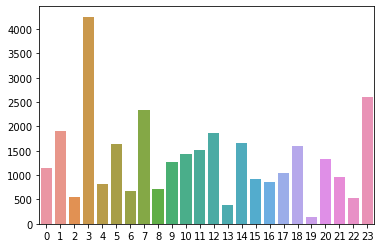

In [15]:
import seaborn as sns 

sns.barplot(pseudo_df.iloc[:, 1:-2].sum().index, pseudo_df.iloc[:, 1:-2].sum().values)

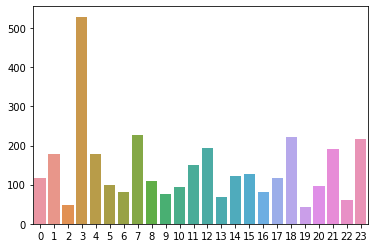

In [11]:
# import seaborn as sns 

# sns.barplot(pseudo_df.iloc[:, 1:-2].sum().index, pseudo_df.iloc[:, 1:-2].sum().values)

In [16]:
pseudo_df.to_csv("./input/rfcx-species-audio-detection/train_ps60.csv", index=False)

## 10秒をtargetに

In [27]:
pseudo_label_dict_all = {"step0":{}, "step1":{}, "step2":{}, "step3":{}, "step4":{}, "step5":{}}

In [28]:
for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((6, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)  # (6, 24)?
    if new_label.sum() == 0:  
        pass
    else:
        for i in range(6):
            pseudo_label_dict_all[f"step{i}"][recording_id] = new_label[i]

In [29]:
pseudo_all_df = pd.DataFrame()
for i in range(6):
    pseudo_df = pd.DataFrame(pseudo_label_dict_all[f"step{i}"]).T
    pseudo_df = pseudo_df.reset_index().rename(columns={'index':'recording_id'})
    pseudo_df["t_min"] = i*10
    pseudo_df["t_max"] = (i+1)*10
    pseudo_all_df = pd.concat([pseudo_all_df, pseudo_df])

In [30]:
pseudo_all_df[pseudo_all_df['recording_id']=='003bec244']

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,10
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,10,20
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,20,30
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,30,40
0,003bec244,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,40,50
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,50,60


In [31]:
pseudo_all_df.reset_index(drop=True)

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,10
1,006ab765f,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,10
2,007f87ba2,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,10
3,0099c367b,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,10
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28357,ffc6031f8,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,50,60
28358,ffd88cd84,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,50,60
28359,ffebe7313,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,50,60
28360,fff163132,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50,60


In [32]:
pseudo_all_df.to_csv("./input/rfcx-species-audio-detection/train_ps10.csv", index=False)

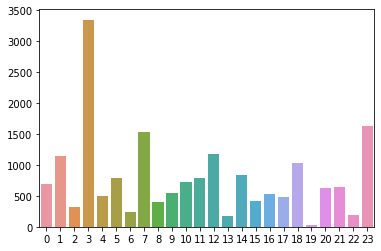

In [33]:
import seaborn as sns

sns.barplot(pseudo_all_df.iloc[:, 1:-2].sum().index, pseudo_df.iloc[:, 1:-2].sum().values)

In [12]:
# # single labelは除外/多すぎるやつも除外
# pseudo_df2 = pseudo_df[~pseudo_df.iloc[:, 1:-2].sum(axis=1).isin([1, 5, 6,7])]

In [13]:
# # single labelは除外/多すぎるやつも除外
# pseudo_df3 = pseudo_df[pseudo_df.iloc[:, 1:-2].sum(axis=1).isin([1])]

In [14]:
# pseudo_df2.iloc[:, 1:-2].sum(axis=1).value_counts()

In [15]:
# sns.barplot(pseudo_df2.iloc[:, 1:-2].sum().index, pseudo_df2.iloc[:, 1:-2].sum().values)

In [16]:
# pseudo_df3 = pseudo_df2.drop(pseudo_df2[pseudo_df2[3]==1].sample(1400).index)

In [17]:
# sns.barplot(pseudo_df3.iloc[:, 1:-2].sum().index, pseudo_df3.iloc[:, 1:-2].sum().values)

In [18]:
# pseudo_df.to_csv("./input/rfcx-species-audio-detection/train_fp_pseudo.csv", index=False)

In [19]:
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,00204008d,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
1,003b04435,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
2,005f1f9a5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,60
3,0072f0839,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
4,0079ff47b,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,ffc6031f8,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
3921,ffd88cd84,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60
3922,ffebe7313,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,60
3923,fff163132,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60


## framewiseでpseudo

In [3]:
pseudo_label_dict_list = []
for fold in range(5):
    # model
    print(f"fold-{fold}")
    model = get_model(config)
    model_name = "EfficientNetSED"
    output_dir = Path("output/0123_181828")
    try:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
    except:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
    model.load_state_dict(ckpt['state_dict'])
    model.eval().to(device)

    output_key = "framewise_logit"
    pseudo_label_dict = {}
    with torch.no_grad():
        # xは複数のlist
        for (x_list, y), recording_id in tqdm(zip(loaders['valid'], all_recording_ids)):
            batch_size = x_list.shape[0]
            x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
            x = x.to(device)
            output = model.model(x)
            output = output[output_key]  # (6,400, 24)
            output = output.view(-1, 24)  # (2400, 24)
            preds = output.sigmoid().detach().cpu().numpy()

            # どれかのクラスが反応している場合、閾値以上のクラスを追加
            labels = []
            for i in range(preds.shape[0]):  # 1frameずつ処理
                pred = preds[i]
                if (pred > 0.9).any():  # 1つのクラスでも0.9以上があればラベル候補とする
                    idx = np.where(pred > PSEUDO_THR)[0]
                    _lab = np.eye(24)[idx]
                    _lab = (_lab.sum(0) > 0).astype(int)  # (1, 24)
                else:
                    _lab = np.zeros(24)
                labels.append(_lab)
            labels = np.stack(labels).astype(int)  # [(1,24)*6] -> (6, 24)
            if labels.sum() == 0:  # 1つのラベルもついていない場合は次のbatchへ
                continue
            pseudo_label_dict[recording_id] = labels

    pseudo_label_dict_list.append(pseudo_label_dict)

fold-0
Loaded pretrained weights for efficientnet-b2
2216it [01:40, 22.07it/s]
fold-1
Loaded pretrained weights for efficientnet-b2
2216it [01:37, 22.69it/s]
fold-2
Loaded pretrained weights for efficientnet-b2
2216it [01:39, 22.18it/s]
fold-3
Loaded pretrained weights for efficientnet-b2
2216it [01:40, 21.96it/s]
fold-4
Loaded pretrained weights for efficientnet-b2
2216it [01:41, 21.92it/s]


In [4]:
pseudo_label_dict_5fold = {}
for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((2400, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 3).astype(int)
    if new_label.sum() == 0:  
        pass
    else:
        pseudo_label_dict_5fold[recording_id] = new_label

In [5]:
len(pseudo_label_dict_5fold)

1132

In [8]:
audio_time = 60
frame_length = 2400
estimated_event_list = []

for recording_id in list(pseudo_label_dict_5fold.keys()):
    for target_idx in range(24):
        allframe = pseudo_label_dict_5fold[recording_id]
        if allframe[:, target_idx].mean() == 0:
            pass
        else:
            detected = np.argwhere(allframe[:, target_idx]).reshape(-1)
            head_idx = 0
            tail_idx = 0
            while True:
                # 音声frameが一つのみ or 音声frameが一つ先のframeと途切れている場合
                if (tail_idx + 1 == len(detected)) or (detected[tail_idx + 1] - detected[tail_idx] != 1):
                    t_min = detected[head_idx] * (audio_time/frame_length)
                    t_max = detected[tail_idx] * (audio_time/frame_length)
                    estimated_event = {
                        "recording_id": recording_id,
                        "species_id": target_idx,
                        "t_min": t_min.astype(np.float16),
                        "t_max": t_max.astype(np.float16),
                    }
                    estimated_event_list.append(estimated_event)
                    head_idx = tail_idx + 1
                    tail_idx = tail_idx + 1
                    if head_idx >= len(detected):
                        break
                else:
                    tail_idx += 1

In [9]:
train_tp_ps = pd.DataFrame(estimated_event_list)
train_tp_ps

,recording_id,species_id,t_min,t_max
0,003bec244,3,10.00,15.976562
1,003bec244,7,1.50,4.476562
2,003bec244,7,5.25,7.476562
3,003bec244,7,13.75,17.468750
4,003bec244,7,20.00,28.218750
...,...,...,...,...
14277,ffb9a7b9a,18,20.00,27.468750
14278,ffb9a7b9a,18,30.00,38.218750
14279,ffb9a7b9a,18,40.00,47.468750
14280,ffb9a7b9a,18,50.00,54.468750


In [10]:
train_tp_ps2 = train_tp_ps[(train_tp_ps['t_max'] - train_tp_ps['t_min']) > 3.0]  # ラベルの秒数で足切り
train_tp_ps2

,recording_id,species_id,t_min,t_max
0,003bec244,3,10.00,15.976562
3,003bec244,7,13.75,17.468750
4,003bec244,7,20.00,28.218750
6,003bec244,7,40.00,43.718750
8,003bec244,7,53.75,58.218750
...,...,...,...,...
14276,ffb9a7b9a,18,10.00,17.468750
14277,ffb9a7b9a,18,20.00,27.468750
14278,ffb9a7b9a,18,30.00,38.218750
14279,ffb9a7b9a,18,40.00,47.468750


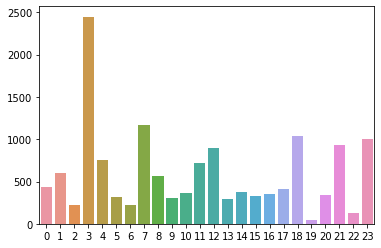

In [11]:
import seaborn as sns
count = train_tp_ps['species_id'].value_counts()
sns.barplot(count.index, count.values)

In [12]:
train_tp_ps3 = train_tp_ps2.sample(1000)

In [14]:
train_tp_ps2.to_csv("./input/rfcx-species-audio-detection/train_tp_frame_ps.csv", index=False)

In [15]:
import pandas as pd
train_tp_ps = pd.read_csv("./input/rfcx-species-audio-detection/train_tp_frame_ps.csv")
train_tp_ps

,recording_id,species_id,t_min,t_max
0,003bec244,3,10.00,15.976562
1,003bec244,7,13.75,17.468750
2,003bec244,7,20.00,28.218750
3,003bec244,7,40.00,43.718750
4,003bec244,7,53.75,58.218750
...,...,...,...,...
7752,ffb9a7b9a,18,10.00,17.468750
7753,ffb9a7b9a,18,20.00,27.468750
7754,ffb9a7b9a,18,30.00,38.218750
7755,ffb9a7b9a,18,40.00,47.468750


In [45]:
label_columns = [i for i in range(24)]

In [47]:
temp = pd.DataFrame(columns=label_columns)

In [49]:
train_tp_ps2 = pd.concat([train_tp_ps, temp])

In [51]:
train_tp_ps2[label_columns] = np.identity(24)[train_tp_ps['species_id'].values].astype(int)
train_tp_ps2

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,recording_id,species_id,t_max,t_min
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,003bec244,3.0,15.976562,10.00
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,003bec244,7.0,17.468750,13.75
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,003bec244,7.0,28.218750,20.00
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,003bec244,7.0,43.718750,40.00
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,003bec244,7.0,58.218750,53.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7752,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,ffb9a7b9a,18.0,17.468750,10.00
7753,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,ffb9a7b9a,18.0,27.468750,20.00
7754,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,ffb9a7b9a,18.0,38.218750,30.00
7755,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,ffb9a7b9a,18.0,47.468750,40.00


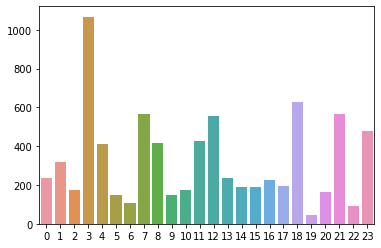

In [59]:
import seaborn as sns
count = train_tp_ps2.iloc[:, :24].sum(0)
sns.barplot(count.index, count.values)

In [60]:
train_tp_ps2.to_csv("./input/rfcx-species-audio-detection/train_tp_frame_ps2.csv", index=False)